# Grandmaster's Path: Decoding Difficulty and Winning Strategies in Wikispeedia

In this notebook, we present the most important things we noticed when analysing the dataset. We then use them to implement interesting additions to the Wikispeedia game, such as inherent difficulty of missions, ingame analysis of played games and an Elo system for players. We propose a way of calculating in-game scores and Elo based on the already existing chess methods.

Our main goal was to gamify Wikispeedia, which makes the game more strategic and motivates players to play thanks to the Elo system and given feedback. Using results from this notebook, the game can be modified in a way where players are given hints at the right time and are given missions of appropriate difficulty.

In [1]:
import numpy as np
import pandas as pd
import os
import sys

from matplotlib import pyplot as plt
from urllib.parse import unquote
import seaborn as sns
import math 
import scipy.stats as stats
import statsmodels.api as sm
import random
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

from utils.data_processing import *
from utils.graph_processing import *
from utils.ingame_processing import *
from models.logistic_regression import LogisticRegression

In [2]:
import importlib
import utils.data_processing

# Reload the ingame_processing module
importlib.reload(utils.graph_processing)

<module 'utils.graph_processing' from '/home/davor/EPFL/Applied_data_analysis/ada-2024-project-outliars/src/utils/graph_processing.py'>

## Main observations from the dataset

In this section, we present our main findings during the preprocessing of the dataset.

In [3]:
articles_df = load_article_df("./data/paths-and-graph/articles.tsv")
links_df = load_links_df("./data/paths-and-graph/links.tsv")
adj_matrix = construct_adjecency_matrix(links_df, articles_df['article_name'].tolist())
node_data = load_or_compute_node_stats("./data/paths-and-graph/node_data.tsv")

Loaded 4604 articles in df of shape (4604, 1)
Loaded 119882 links in df of shape (119882, 2)
After adding missing links, there are 119888 links in df
Loaded 4604 node stats


In [4]:
node_data['degree'].max()

295

### Articles and links

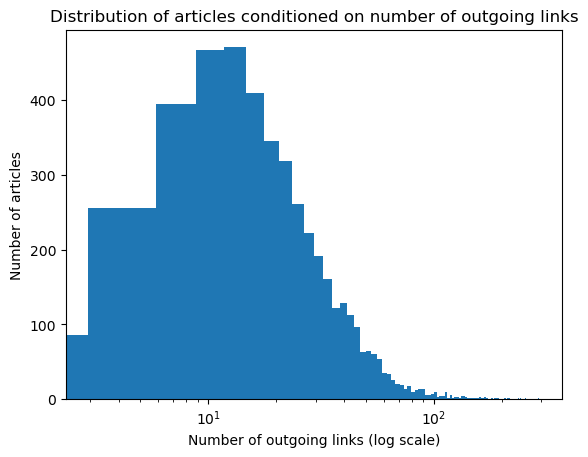

In [5]:
outgoing_links = adj_matrix.apply(lambda a: a.sum(), axis=1)  # Distribution of number of outgoing links per article
bins_100 = plt.hist(outgoing_links, bins=100)

plt.xscale('log')  # log x axis
plt.xlabel("Number of outgoing links (log scale)")
plt.ylabel("Number of articles")
plt.title("Distribution of articles conditioned on number of outgoing links")
plt.show()

In [6]:
print(outgoing_links.describe())
print("The article with the biggest number of outgoing links is", outgoing_links.idxmax())

count    4604.000000
mean       26.039965
std        24.202288
min         0.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
dtype: float64
The article with the biggest number of outgoing links is United_States


In [7]:
dead_end = outgoing_links[outgoing_links == 0].index.tolist()
print(len(dead_end), "articles are dead ends")

17 articles are dead ends


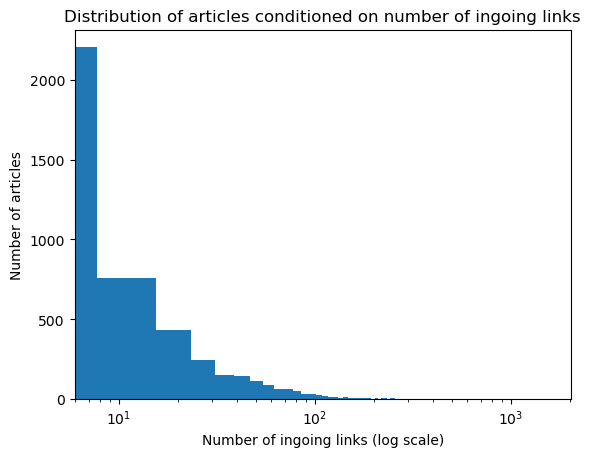

In [8]:
ingoing_links = adj_matrix.apply(lambda a: a.sum(), axis = 0) # Distribution of number of ingoing links per article
plt.hist(ingoing_links, bins = 200)

plt.xscale('log')  # log x axis
plt.xlabel("Number of ingoing links (log scale)")
plt.ylabel("Number of articles")
plt.title("Distribution of articles conditioned on number of ingoing links")
plt.show()

In [9]:
print(ingoing_links.describe())
print("The article with the biggest number of ingoing links is", ingoing_links.idxmax())

count    4604.000000
mean       26.039965
std        62.746310
min         0.000000
25%         2.000000
50%         8.000000
75%        25.000000
max      1551.000000
dtype: float64
The article with the biggest number of ingoing links is United_States


In [10]:
isolated_target = ingoing_links[ingoing_links == 0].index.tolist()
print(len(isolated_target), "articles are unreachable from other articles")
print("For example: ", isolated_target[:10])

466 articles are unreachable from other articles
For example:  ['Áedán_mac_Gabráin', 'Óengus_I_of_the_Picts', '€2_commemorative_coins', '2005_Hertfordshire_Oil_Storage_Terminal_fire', '2005_Lake_Tanganyika_earthquake', 'A._E._J._Collins', 'AC_DC', 'ATLAS_experiment', 'A_Wrinkle_in_Time', 'Abacá']


We can notice that a certain number of articles appears to have a very small number of ingoing and outgoing links. Having articles with 0 ingoing and outgoing links can lead to impossible missions, so we analyse these statistics.

In [11]:
all_links = pd.concat([ingoing_links, outgoing_links], axis = 1)
all_links.columns = ['Ingoing Links', 'Outgoing Links']
print(len(all_links[(all_links['Ingoing Links'] == 0) & (all_links['Outgoing Links'] == 0)].index.tolist()), "articles with both 0 ingoing and outgoing links: ")
isolated = all_links[(all_links['Ingoing Links'] == 0) & (all_links['Outgoing Links'] == 0)].index.tolist()
isolated

12 articles with both 0 ingoing and outgoing links: 


['Badugi',
 'Color_Graphics_Adapter',
 'Donation',
 'Douglas_DC-4',
 'Lone_Wolf_(gamebooks)',
 'Private_Peaceful',
 'Schatzki_ring',
 'Suikinkutsu',
 'Underground_(stories)',
 'Vacutainer',
 'Wikipedia_Text_of_the_GNU_Free_Documentation_License',
 'Wowpurchase']

This made us suspiscious, as we noticed that each article contains a link to the 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' page in the footer. We therefore decided to analyse links used in games and check if there are other missing links in the links part of the dataset when analysing the games.

### Invalid games and links

Here, we analyse data available from already played games from the dataset and notice several other problems linked to the dataset.

In [12]:
finished_df = load_finished_df("./data/paths-and-graph/paths_finished.tsv")
unfinished_df = load_unfinished_df("./data/paths-and-graph/paths_unfinished.tsv")

earliest_finished = finished_df['timestamp'].min()
earliest_unfinished = unfinished_df['timestamp'].min()
finished_before_unfinished = finished_df[finished_df['timestamp'] < earliest_unfinished]
print("The earliest finished game was played on", earliest_finished, "while the earliest unfinished game was played on", earliest_unfinished)
print(finished_before_unfinished.shape[0], "finished games are recorded before the first unfinished one.")

Loaded 51318 finished paths in df of shape (51318, 7)
Loaded 24875 unfinished paths in df of shape (24875, 8)
The earliest finished game was played on 2008-08-18 21:29:32 while the earliest unfinished game was played on 2011-02-07 05:02:15
28073 finished games are recorded before the first unfinished one.


The earliest unfinished game was recorded more than 2 years laten than the earliest recorded finished game. As it is highly unlikely that 28073 games were played and none was lost, we can conclude that the system might not have differenciated finished from unfinished games in the past. Since it is important to know whether the person won or lost the game for our project, we will not use the finished games recorded before the first unfinished one in our analysis. 

In [13]:
games, _ = preprocess_and_concat_unfinished_and_finished(unfinished_df, finished_df)
games_src = games.set_index("source")
games_src.head()

After filtering all paths after 2011-02-07 05:02:15
we kept 23245 paths out of 51318 finished paths
There are 24875 unfinished paths


,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,target,timestamp,type_end
source,,,,,,,,,,
14th_century,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,African_slave_trade,2011-02-15 03:26:49,NaN
14th_century,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,African_slave_trade,2012-08-12 06:36:52,NaN
14th_century,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,African_slave_trade,2012-10-03 21:10:40,NaN
14th_century,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,John_F._Kennedy,2013-04-23 15:27:08,NaN
14th_century,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,John_F._Kennedy,2013-07-03 22:26:54,NaN


We will now check if there exist missions which are impossible, i.e. where there is no existing path between the source and target article.

In [14]:
distance_df = read_distance_matrix('./data/paths-and-graph/shortest-path-distance-matrix.txt', articles_df)

In [15]:
counter, typo_src, typo_trg, isol_src, isol_trg = find_impossible_games(games_src, articles_df, dead_end, isolated_target, distance_df)

print(f"In total, {counter} played missions were impossible to win because of no existing shortest path")
print("-----------------")
print()
print("Games with dead end as source: ")
for i in isol_src:
    print(i)
print("-----------------")
print()
print("Games with unreachable node as target: ")
for i in isol_trg:
    print(i)
print()
print(f"Total typos as source article: {len(typo_src)}, total typos as target article: {len(typo_trg)}")
print("-----------------")
print()
print("Typos as target articles: ")
for i in typo_trg:
    print(i)
print("-----------------")
print()
print("Typos as source articles: ")
for i in typo_src:
    print(i)


Impossible games because of no existing path:
Bird - Wikipedia_Text_of_the_GNU_Free_Documentation_License
Oasis_(band) - Final_Fantasy_(video_game)
Adolf_Hitler - The_Frogs
Anne_Frank - Final_Fantasy_(video_game)
Anne_Frank - Final_Fantasy_(video_game)
Toy - Lego
Hymenoptera - Portuguese_Communist_Party
Private_Peaceful - Unix
Quantum_mechanics - Blue_Tit
In total, 9 played missions were impossible to win because of no existing shortest path
-----------------

Games with dead end as source: 
Private_Peaceful
-----------------

Games with unreachable node as target: 
Wikipedia_Text_of_the_GNU_Free_Documentation_License
The_Frogs
Blue_Tit

Total typos as source article: 0, total typos as target article: 24
-----------------

Typos as target articles: 
Fats
English
Netbook
Macedonia
Rat
Christmas
Kashmir
Great
Long_peper
Podcast
Black_ops_2
Sportacus
Charlottes_web
Georgia
Usa
Test
Adolph_Hitler
Western_Australia
Mustard
The
The_Rock
Bogota
_Zebra
Rss
-----------------

Typos as source ar

As seen in the output, the target articles contain a lot of typos. Some pairs of source-article that were given as a game were not winnable. Next, we are going to look at possible ways an unfinished game could have ended. 

In [16]:
games_src['type_end'].value_counts()

type_end
restart    15552
timeout     9323
Name: count, dtype: int64

In [17]:
print(f"{100*games_src[games_src['type_end'] == 'timeout'].shape[0]/games_src.shape[0]:.2f}% of played games ({100*unfinished_df[unfinished_df['type_end'] == 'timeout'].shape[0]/unfinished_df.shape[0]:.2f}% of lost games) ended in a timeout")

19.37% of played games (37.48% of lost games) ended in a timeout


We observe that a lot of games ended in a timeout. Since we can't be sure why people gave up (more precisely, if it is linked to the game difficulty or not), we decide to remove those games. This allows us to potentially use the duration in our later analysis.

Additionally, we observed a number of links were not present in the link part of the dataset, although these connections really exist between articles. We added these manually when loading the links_df dataframe. The list of such links consists of all articles' connection to the 'Wikipedia_Text_of_the_GNU_Free_Documentation_License' page, as well as the following links:

In [18]:
get_manually_added_links()

[('Finland', 'Åland'),
 ('Republic_of_Ireland', 'Éire'),
 ('Claude_Monet', 'Édouard_Manet'),
 ('Impressionism', 'Édouard_Manet'),
 ('Ireland', 'Éire'),
 ('Francisco_Goya', 'Édouard_Manet')]

### Problems related to played games

Let's load the preprocessed games (things mentioned above are taken into accout).

In [19]:
games = load_preprocessed_games('./data/paths-and-graph/paths_finished.tsv', './data/paths-and-graph/paths_unfinished.tsv', "./data/paths-and-graph/articles.tsv")

Loaded 51318 finished paths in df of shape (51318, 7)
Loaded 24875 unfinished paths in df of shape (24875, 8)
After filtering all paths after 2011-02-07 05:02:15
we kept 23245 paths out of 51318 finished paths
There are 24875 unfinished paths
Loaded 4604 articles in df of shape (4604, 1)
Pruning invalid games. Initially we have 48120 games
Pruned invalid games. Now we have 48092 valid games
Removed 101 games that contained non existing links
After removing timeouted games, there are 38696 games left


In [20]:
games.head()

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp,type_end
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,NaN
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,NaN
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,NaN
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,NaN
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,NaN


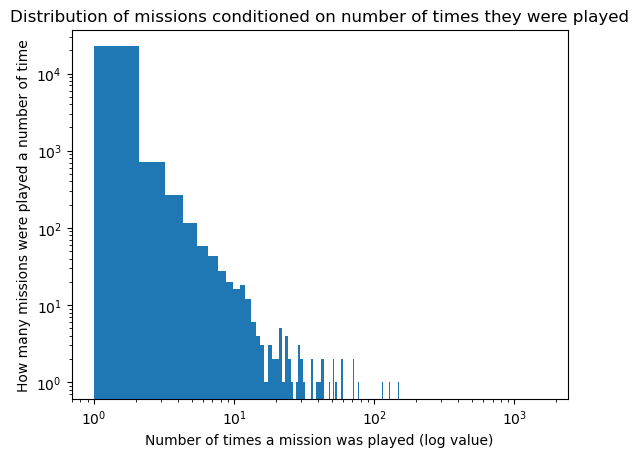

In [21]:
count_missions = games.groupby(['source', 'target']).size() 

plt.hist(count_missions, bins = 1500, log=True)
plt.xscale('log')  # log x axis
plt.xlabel("Number of times a mission was played (log value)")
plt.ylabel("How many missions were played a number of time")
plt.title("Distribution of missions conditioned on number of times they were played")
plt.show()

In [22]:
print(f"{100*count_missions[count_missions > 10].count() / count_missions.shape[0]:.2f}% of missions were played more than 10 times") # % of missions played more than 10 times
print(f"{100 * (count_missions[(count_missions == 1) | (count_missions == 2)].count() )/ count_missions.shape[0]:.2f}% of missions were played once or twice") # % of missions played once or twice

0.41% of missions were played more than 10 times
94.29% of missions were played once or twice


We immediately notice a big problem: most missions were played only once or twice. This makes it very hard to rely on data from played games to conclude anything about the inherent (depending only on the source and target) mission difficulty.

We could also use given difficulty ratings to predict inherent difficulty, but the problem here is that difficulty ratings were only given for won games, which means player are more likely to rate the mission as an easier won (since they won it). This can be seen in the distribution of given ratings:

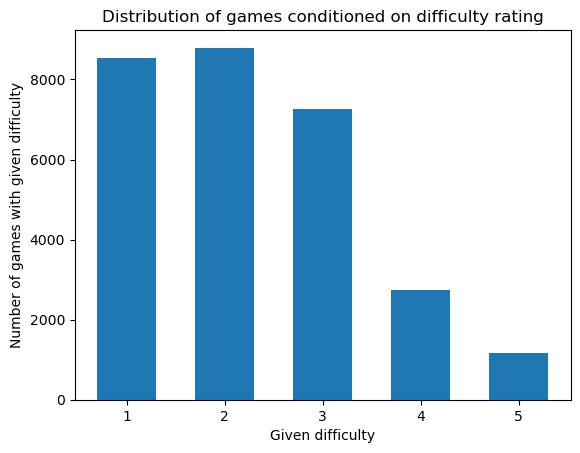

In [23]:
difficulty_counts = finished_df['difficulty_rating'].value_counts().sort_index()

plt.bar(difficulty_counts.index, difficulty_counts.values, edgecolor=None, width=0.6)
plt.xlabel("Given difficulty")
plt.ylabel("Number of games with given difficulty")
plt.title("Distribution of games conditioned on difficulty rating")
plt.show()

Another problem is that, even among won games, difficulty ratings were not always given:

In [24]:
print(f"Percentage of missing difficulty ratings in won games: {(100 * finished_df.difficulty_rating.isna().sum() / finished_df.difficulty_rating.shape)[0]:.2f}:%")

Percentage of missing difficulty ratings in won games: 44.46:%


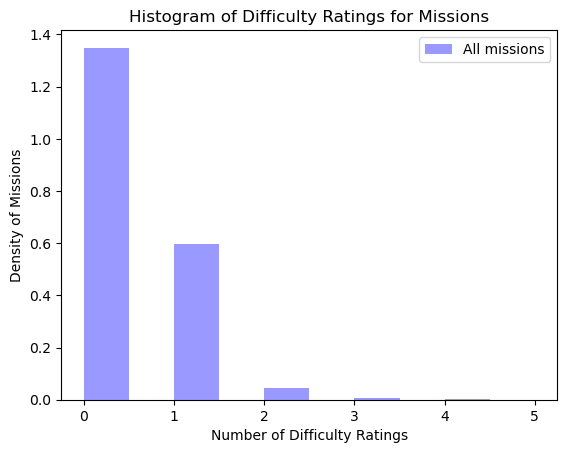

In [25]:
games_diff = games.groupby(['source', 'target']).count()['difficulty_rating'] 

plt.hist(games_diff, range=(0, 5), alpha=0.4, color='blue', label='All missions', density = True)

plt.xlabel("Number of Difficulty Ratings")
plt.ylabel("Density of Missions")
plt.title("Histogram of Difficulty Ratings for Missions")
plt.legend()

plt.show()

Even missions for which difficulty rating exists, we don't have enough of them to conclude anything about the mission's difficulty.

### Players in the dataset

The dataset does not contain IPs, but only their hashIP.

## Inherent difficulty

In [26]:
unique_game_stats_df = load_unique_source_target_pair_stats("./data/paths-and-graph/pair_data.tsv")
unique_game_stats_df.head()

Loaded 121896 unique source-target pair stats


,,shortest_path_length,shortest_path_count,max_sp_pagerank,max_sp_avg_pagerank,avg_sp_avg_pagerank,one_longer_path_count,max_ol_pagerank,max_ol_avg_pagerank,avg_ol_avg_pagerank,two_longer_pagerank,max_tl_pagerank,max_tl_avg_pagerank
source,target,,,,,,,,,,,,
Technology,Literacy,2,2,0.001187,0.000846,0.000731,29,0.002247,0.001518,0.000808,1315,0.007202,0.002939
Oxygen,Beer,2,3,0.001231,0.001180,0.001053,47,0.001231,0.001079,0.000862,716,0.007202,0.002590
United_States_Declaration_of_Independence,War,2,3,0.007202,0.003687,0.001366,49,0.007202,0.003679,0.001547,1561,0.007202,0.004011
Gray_reef_shark,Monkey,3,2,0.001736,0.000731,0.000414,77,0.004916,0.001404,0.000475,2386,0.007202,0.002582
Forest,Shoshone_National_Forest,4,5,0.001745,0.000689,0.000441,121,0.007202,0.002244,0.000758,3717,0.007202,0.002690


In [27]:
node_stats_df = load_node_stats("./data/paths-and-graph/node_data.tsv")
node_stats_df.head()

Loaded 4604 node stats


,degree,closeness,betweenness,pagerank
article_name,,,,
10th_century,27,0.323966,5575.09,0.000500
11th_century,49,0.336178,6653.51,0.000435
12th_century,46,0.338251,14201.00,0.000561
13th_century,35,0.321630,8544.39,0.000586
14th_century,32,0.325238,5366.38,0.000470


In [28]:
embeddings_df = load_embeddings("./data/article_embeddings_smaller.csv")
embeddings_df.head()

Loaded 4604 embeddings in df of shape (4604, 1)


,embedding
article_name,
10th_century,"[-0.050105415, 0.09074813, 0.008811204, -0.051..."
11th_century,"[-0.042490385, 0.061723217, -0.020333063, -0.0..."
12th_century,"[-0.032364372, 0.037580367, -0.052070234, -0.1..."
13th_century,"[-0.07914139, 0.059444286, 0.020845776, -0.100..."
14th_century,"[-0.040906686, 0.122400954, -0.04961793, 0.007..."


In [29]:
fame_df = load_fame("./src/data/topic_fame_updated.csv")
fame_df.head()

,fame_score
article_name,
10th_century,4.0
11th_century,4.0
12th_century,4.0
13th_century,4.0
14th_century,8.0


In [30]:
# Create a copy of the games dataframe to use for regression analysis of inherent difficulty
regression_games_df = games.copy()

# Attach the stats which are related to paths from source to destination nodes
regression_games_df = regression_games_df.merge(unique_game_stats_df, on=['source', 'target'], how='left')
regression_games_df.dropna(subset=['shortest_path_length'], inplace=True)

# Attach the embeddings of the source and target nodes
regression_games_df = compute_cosine_similarity(regression_games_df, embeddings_df)

# Attach the node stats of the source and target nodes
regression_games_df = merge_with_node_data(regression_games_df, node_stats_df)

# Attach the fame of the source and target nodes
regression_games_df = merge_with_fame_data(regression_games_df, fame_df)

regression_games_df.head()

,difficulty_rating,duration,finished,hashIP,num_backward,path,path_length,source,target,timestamp,...,degree_source,closeness_source,betweenness_source,pagerank_source,degree_target,closeness_target,betweenness_target,pagerank_target,fame_score_source,fame_score_target
0,NaN,166,True,6a3701d319fc3754,0,"[14th_century, 15th_century, 16th_century, Pac...",9,14th_century,African_slave_trade,2011-02-15 03:26:49,...,32,0.325238,5366.38,0.00047,25,0.335511,102.483,0.000028,8.0,6.0
1,3.0,88,True,3824310e536af032,0,"[14th_century, Europe, Africa, Atlantic_slave_...",5,14th_century,African_slave_trade,2012-08-12 06:36:52,...,32,0.325238,5366.38,0.00047,25,0.335511,102.483,0.000028,8.0,6.0
2,NaN,138,True,415612e93584d30e,0,"[14th_century, Niger, Nigeria, British_Empire,...",8,14th_century,African_slave_trade,2012-10-03 21:10:40,...,32,0.325238,5366.38,0.00047,25,0.335511,102.483,0.000028,8.0,6.0
3,3.0,175,True,015245d773376aab,0,"[14th_century, Italy, Roman_Catholic_Church, H...",7,14th_century,John_F._Kennedy,2013-04-23 15:27:08,...,32,0.325238,5366.38,0.00047,69,0.348326,16585.800,0.000243,8.0,9.0
4,NaN,110,True,5295bca242be81fe,0,"[14th_century, Europe, North_America, United_S...",6,14th_century,John_F._Kennedy,2013-07-03 22:26:54,...,32,0.325238,5366.38,0.00047,69,0.348326,16585.800,0.000243,8.0,9.0


In [31]:
# Remove columns that are not needed for the regression analysis of inherent difficulty
regression_games_df.drop(
    columns=[
        'hashIP', 'timestamp', 'path', 'difficulty_rating', 'type_end',
        'duration', 'path_length', 'num_backward'
    ], 
    inplace=True
)

# The number of paths is better when log-transformed
regression_games_df['shortest_path_count'] = regression_games_df['shortest_path_count'].apply(lambda x: np.log2(x + 1e-2))
regression_games_df['one_longer_path_count'] = regression_games_df['one_longer_path_count'].apply(lambda x: np.log2(x + 1e-2))
regression_games_df['two_longer_pagerank'] = regression_games_df['two_longer_pagerank'].apply(lambda x: np.log2(x + 1e-2))

# Change the type of finished to a float for logistic regression
regression_games_df['finished'] = regression_games_df['finished'].astype(float)

print(regression_games_df.shape)
print(regression_games_df.columns)

(36663, 26)
Index(['finished', 'source', 'target', 'shortest_path_length',
       'shortest_path_count', 'max_sp_pagerank', 'max_sp_avg_pagerank',
       'avg_sp_avg_pagerank', 'one_longer_path_count', 'max_ol_pagerank',
       'max_ol_avg_pagerank', 'avg_ol_avg_pagerank', 'two_longer_pagerank',
       'max_tl_pagerank', 'max_tl_avg_pagerank', 'cosine_sim_source_target',
       'degree_source', 'closeness_source', 'betweenness_source',
       'pagerank_source', 'degree_target', 'closeness_target',
       'betweenness_target', 'pagerank_target', 'fame_score_source',
       'fame_score_target'],
      dtype='object')


In [ ]:
# Include all the features in the regression model
features_all = [
    'shortest_path_length',
    'shortest_path_count', 
    'max_sp_pagerank', 
    'max_sp_avg_pagerank',
    'avg_sp_avg_pagerank', 
    'one_longer_path_count', 
    'max_ol_pagerank',
    'max_ol_avg_pagerank', 
    'avg_ol_avg_pagerank', 
    'two_longer_pagerank',
    'max_tl_pagerank', 
    'max_tl_avg_pagerank', 
    'cosine_sim_source_target',
    'degree_source', 
    'closeness_source', 
    'betweenness_source',
    'pagerank_source', 
    'degree_target', 
    'closeness_target',
    'betweenness_target', 
    'pagerank_target', 
    'fame_score_source', 
    'fame_score_target'
]

model_all = LogisticRegression(regression_games_df, features_all, has_constant_term=True)
model_all.fit()

Class distribution: finished
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64
Total number of samples: 26876
Optimization terminated successfully.
         Current function value: 0.632209
         Iterations 5
Training Set Metrics:
Threshold:   0.5040
F1 Score:    0.6366
Precision:   0.6366
Accuracy:    0.6366
              precision    recall  f1-score   support

         0.0     0.6237    0.6198    0.6218      2688
         1.0     0.6222    0.6261    0.6241      2688

    accuracy                         0.6230      5376
   macro avg     0.6230    0.6230    0.6230      5376
weighted avg     0.6230    0.6230    0.6230      5376



In [39]:
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                21500
Model:                          Logit   Df Residuals:                    21476
Method:                           MLE   Df Model:                           23
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                 0.08791
Time:                        19:53:26   Log-Likelihood:                -13593.
converged:                       True   LL-Null:                       -14903.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.015     -0.331      0.740      -0.034       0.024
x1            -0.7380      0.038    -19.301      0.000      -0.813      -0.663
x2            -0.0113      0.053     -0.215      0.830      -0.114       0.092
x3            -0.0508      0.048     -1.056      0.291      -0.145       0.044
x4            -0.0011      0.062     -0.018      0.986      -0.122       0.119
x5             0.0340      0.037      0.918      0.359      -0.039       0.107
x6             0.4191      0.072      5.833      0.000       0.278       0.560
x7            -0.1755      0.030     -5.860      0.000      -0.234      -0.117
x8             0.2197      0.052      4.235      0.000       0.118       0.321
x9            -0.0596      0.038     -1.554      0.120      -0.135       0.016
x10           -0.0380      0.041     -0.918      0.359      -0.119       0.043
x11            0.0070      0.023      0.300      0.764      -0.039       0.053
x12            0.0107      0.039      0.273      0.785      -0.066       0.088
x13           -0.0137      0.016     -0.831      0.406      -0.046       0.019
x14           -0.0474      0.031     -1.530      0.126      -0.108       0.013
x15           -0.2343      0.028     -8.477      0.000      -0.288      -0.180
x16            0.1491      0.032      4.645      0.000       0.086       0.212
x17           -0.1438      0.030     -4.726      0.000      -0.203      -0.084
x18            0.2524      0.034      7.514      0.000       0.187       0.318
x19           -0.2505      0.028     -8.802      0.000      -0.306      -0.195
x20           -0.1501      0.030     -4.942      0.000      -0.210      -0.091
x21            0.2082      0.038      5.496      0.000       0.134       0.282
x22            0.0185      0.016      1.182      0.237      -0.012       0.049
x23            0.0910      0.017      5.370      0.000       0.058       0.124
==============================================================================
"""

In [ ]:
features_shortest = ['shortest_path_length', 'shortest_path_count']

model_shortest = LogisticRegression(regression_games_df, features_shortest)
model_shortest.fit()

Class distribution: finished
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64
Total number of samples: 26876
Optimization terminated successfully.
         Current function value: 0.649811
         Iterations 5
Training Set Metrics:
Threshold:   0.5020
F1 Score:    0.6212
Precision:   0.6213
Accuracy:    0.6213
              precision    recall  f1-score   support

         0.0     0.6016    0.6112    0.6064      2688
         1.0     0.6049    0.5952    0.6000      2688

    accuracy                         0.6032      5376
   macro avg     0.6033    0.6032    0.6032      5376
weighted avg     0.6033    0.6032    0.6032      5376



In [33]:
model_shortest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               finished   No. Observations:                21500
Model:                          Logit   Df Residuals:                    21498
Method:                           MLE   Df Model:                            1
Date:                Fri, 20 Dec 2024   Pseudo R-squ.:                 0.06252
Time:                        19:20:30   Log-Likelihood:                -13971.
converged:                       True   LL-Null:                       -14903.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7516      0.019    -39.742      0.000      -0.789      -0.715
x2             0.3502      0.017     20.549      0.000       0.317       0.384
==============================================================================
"""

In [34]:
features_pagerank = ['pagerank_target']

model_pagerank = LogisticRegression(regression_games_df, features_pagerank, has_constant_term=True)
model_pagerank.fit()

Class distribution: finished
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64
Total number of samples: 26876
Optimization terminated successfully.
         Current function value: 0.660773
         Iterations 6
Training Set Metrics:
Threshold:   0.4460
F1 Score:    0.6337
Precision:   0.6337
Accuracy:    0.6337
              precision    recall  f1-score   support

         0.0     0.6282    0.6306    0.6294      2688
         1.0     0.6292    0.6269    0.6280      2688

    accuracy                         0.6287      5376
   macro avg     0.6287    0.6287    0.6287      5376
weighted avg     0.6287    0.6287    0.6287      5376



## In-game tracking

## Elo system